In [1]:
import rp
from easydict import EasyDict
from source.peekaboo import make_image_square
from rp import ic

Current Process: 108837 python


In [2]:
outputs_folder='untracked/dep_peekaboo_RefMatte'

In [3]:
result_folders=outputs_folder
result_folders=rp.get_all_folders(result_folders)
result_folders=[rp.get_all_folders(x) for x in result_folders]
result_folders=rp.list_flatten(result_folders)

In [4]:
result_folders[0]

'/nfs/ws3/hdd2/ws1nfs/ryan/CleanCode/Projects/Peekaboo/Experiments/Github/Diffusion-Illusions/untracked/dep_peekaboo_RefMatte/rim_rw_03d21fba.A young white man in a white t-shirt and grey pants located at the right part of the picture.midas_raster_bilateral_low_grav_bilat0rgb_sd15__100iter/002'

In [5]:
rp.ic(len(result_folders))

ic| len(result_folders): 338


338

In [26]:
class Result:
    def __init__(self, path):
        self.path=path
        
        self.trial_num=int(rp.get_folder_name(self.path)) # Like 000, 001 etc
        self.params=EasyDict(rp.load_json(rp.path_join(self.path,'params.json')))
        self.prompt=self.params.extra_data.prompt
        self.name=self.params.extra_data.entry.image_name
        self.preset_name=rp.get_folder_name(rp.get_parent_folder(self.path)).split('.')[-1]
        self.square_image_method=self.params.extra_data.square_image_method
        
        self.alpha_path         =rp.path_join(self.path,'alphas','0.png')
        self.image_path         =rp.path_join(self.path,'image.png')
        self.preview_image_path =rp.path_join(self.path,'preview_image.png')
        self.mask_path          =rp.path_join('datasets/RefMatte_RW_100',self.params.extra_data.entry.mask_path)
        self.original_image_path=rp.path_join('datasets/RefMatte_RW_100',self.params.extra_data.entry.image_path)
        self.mask_name=rp.get_file_name(self.mask_path, include_file_extension=False)

        self.original_mask =rp.load_image(self.mask_path          ,use_cache=True)
        self.original_image=rp.load_image(self.original_image_path,use_cache=True)
        self.alpha         =rp.load_image(self.alpha_path         ,use_cache=True)
        self.image         =rp.load_image(self.image_path         ,use_cache=True)
        self.preview_image =rp.load_image(self.preview_image_path ,use_cache=True)
        self.mask=rp.cv_resize_image(make_image_square(self.original_mask, self.square_image_method),rp.get_image_dimensions(self.alpha))
        
        print(self)
        
    def __repr__(self):
        return 'Result(%s, %s, %s)'%(self.mask_name, self.trial_num, self.preset_name)
    
    @property 
    def best_iou(self):
        return get_best_iou(self)
    
def try_load_result(path):
    try:
        return Result(path)
    except Exception as e:
        #AttributeError: 'EasyDict' object has no attribute 'extra_data'
        rp.fansi_print(e,'red')

In [34]:
from rp import *
def get_mask_iou(*masks):
    """Calculates the IOU (intersection over union) of multiple binary masks"""
    masks=detuple(masks)
    assert all(is_image(mask) for mask in masks), 'All masks must be images as defined by rp.is_image'
    assert len(set(get_image_dimensions(mask) for mask in masks))==1, 'All masks must have the same dimensions, but got shapes '+repr(set(get_image_dimensions(mask) for mask in masks))
    masks = as_numpy_array([as_binary_image(as_grayscale_image(mask)) for mask in masks])
    intersection = np.min(masks, axis=0)
    union = np.max(masks, axis=0)
    return np.sum(intersection) / np.sum(union)

def get_iou(result, threshold=.1, mask=None):
    return get_mask_iou(mask if mask is not None else result.mask, rp.as_float_image(result.alpha)>threshold)

@memoized
def get_best_iou(result, mask=None):
    return max(get_iou(result, threshold, mask) for threshold in [.1,.2,.3,.4,.5,.6,.7,.8,.9])

In [36]:
from tqdm import tqdm
import random
from collections import defaultdict
from typing import List

@memoized
def alpha_filter_1(alpha):
    pred_img=alpha
    alpha=pred_img
    std=alpha.std()
    alpha=alpha-alpha.mean()*.56
    alpha=alpha/std/(2+.1)
    pred_img=alpha
    pred_img=rp.cv_gauss_blur(pred_img,10)
    R=45
    pred_img=rp.cv_dilate(pred_img,R,circular=True)
    # pred_img=rp.cv_erode(pred_img,R-6,circular=True)
    pred_img=rp.cv_erode(pred_img,R,circular=True)
    R=9
    pred_img=rp.cv_gauss_blur(pred_img,80)
    pred_img=rp.cv_erode(pred_img,R,circular=True)
    pred_img=rp.cv_dilate(pred_img,R,circular=True)
    pred_img=rp.as_float_image(pred_img)
    return pred_img

@memoized
def alpha_filter_2(alpha):
    pred_img=alpha
    alpha=pred_img
    std=alpha.std()
    #alpha=alpha-alpha.mean()*.56
    #alpha=alpha/std/(2+.1)
    #pred_img=alpha
    #pred_img=rp.cv_gauss_blur(pred_img,10)
    
    R=40
    pred_img=rp.cv_dilate(pred_img,R,circular=True)
    pred_img=rp.cv_erode(pred_img,R,circular=True)
    # R=10
    # pred_img=rp.cv_gauss_blur(pred_img,10)
    # pred_img=rp.cv_erode(pred_img,R,circular=True)
    # pred_img=rp.cv_dilate(pred_img,R,circular=True)
    pred_img=rp.as_float_image(pred_img)
    return pred_img


def chunkoozle(alpha,r=10,iter=1):
    #Bad name maybe
    alpha=as_grayscale_image(alpha)
    alpha=as_float_image(alpha)
    a=alpha
    for _ in range(iter):
        oa=a
        a=cv_dilate(a,r,circular=True)
        a=cv_erode(a,r,circular=True)
        a=as_float_image(a)
        a=np.maximum(a,oa)
    return a

@memoized
def alpha_filter_3(alpha):
    alpha=chunkoozle(alpha,60,2)
    alpha=rp.as_float_image(alpha)
    return alpha

@memoized
def alpha_filter_4(alpha):
    alpha=chunkoozle(alpha,90,3)
    alpha=rp.as_float_image(alpha)
    return alpha

@memoized
def alpha_filter_5(alpha):
    alpha=chunkoozle(alpha,70,1)
    alpha=rp.as_float_image(alpha)
    return alpha


In [28]:
results = [x for x in rp.par_map(try_load_result, result_folders) if x is not None]

invalid literal for int() with base 10: '008_ENbtCFHbpp'
Result(rim_rw_03d21fba_2, 0, midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter)
Result(rim_rw_22e45b23_6, 4, midas_raster_bilateral_low_grav_bilat0rgb_sd15__100iter)
Result(rim_rw_03d21fba_2, 2, midas_raster_bilateral_low_grav_bilat0rgb_sd15__100iter)
Result(rim_rw_212f93e5_1, 7, midas_raster_bilateral_low_grav_bilat0rgb_sd15__100iter)
Result(rim_rw_22e45b23_6, 4, midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter)
Result(rim_rw_6537667a_1, 2, midas_raster_bilateral_low_grav_bilat0rgb_sd15__200iter)
Result(rim_rw_43529238_3, 5, midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter)
Result(rim_rw_3357db2b_1, 5, midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter)
Result(rim_rw_7698ca97_2, 1, raster_bilateral)
Result(rim_rw_35c91f53_1, 4, midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter)
Result(rim_rw_3aa3eab1_1, 5, midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter)
Result(rim_rw_22e45b23_6, 4, raster_bilate

In [10]:
best_results = sorted(results, key=get_best_iou, reverse=True)

0.9650660489576159


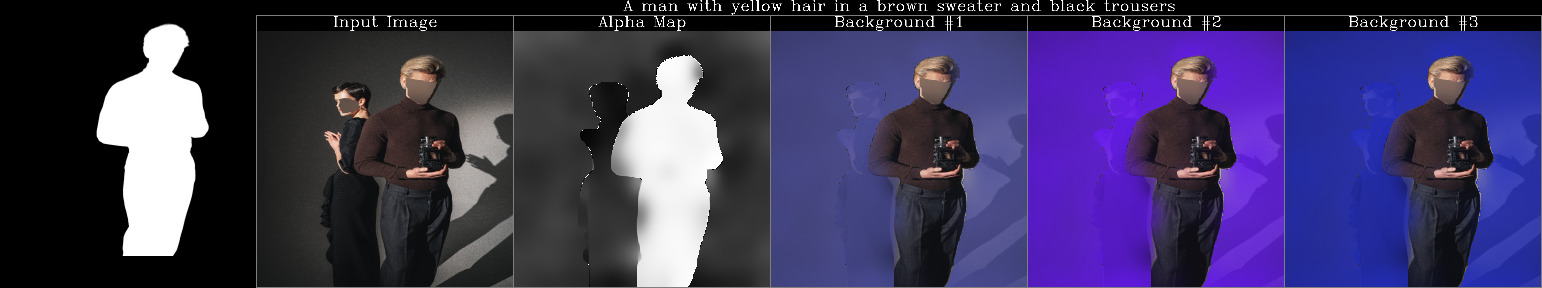



0.9608124104417171


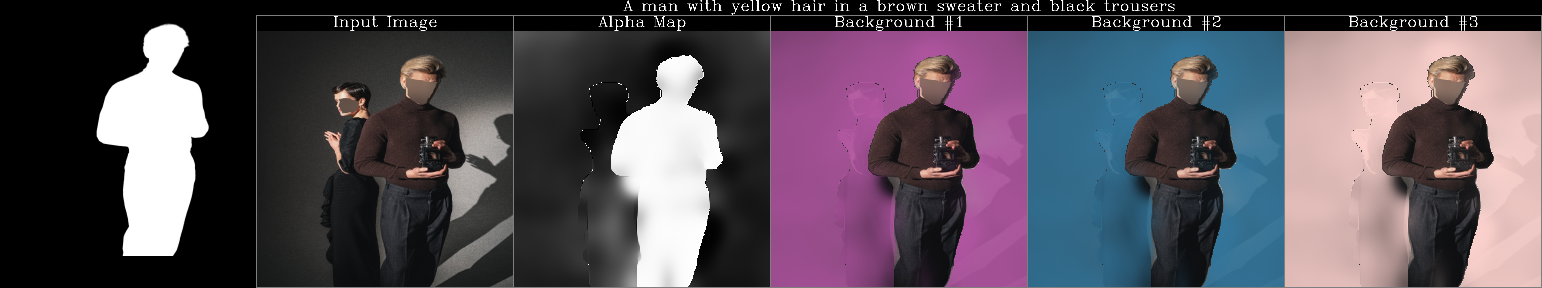



0.9539951573849879


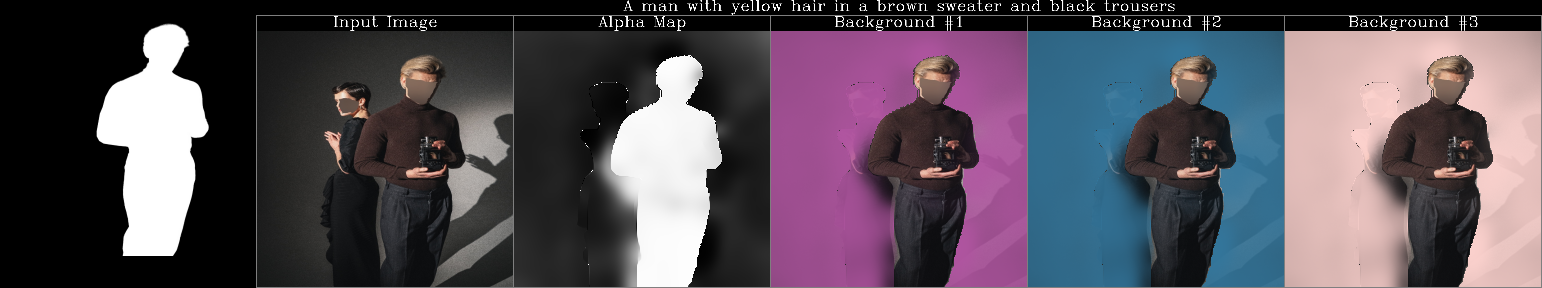



0.9301070873865773


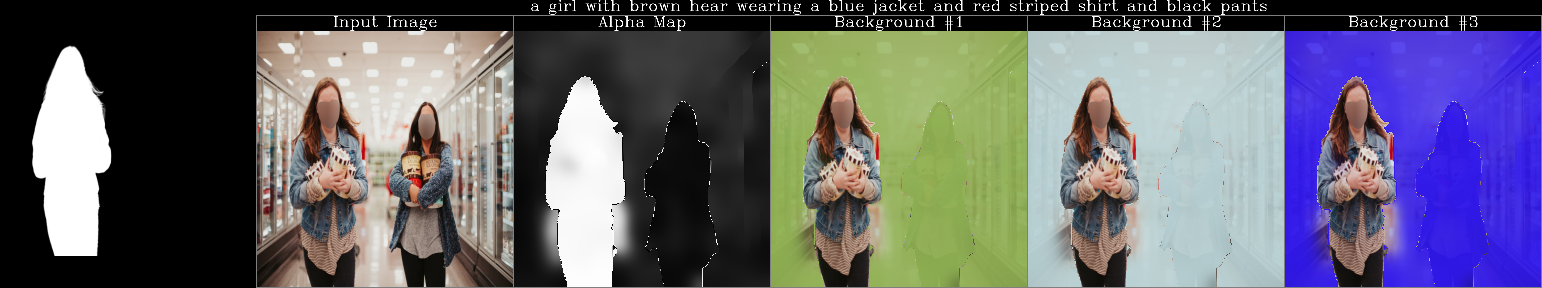



0.9164025954428852


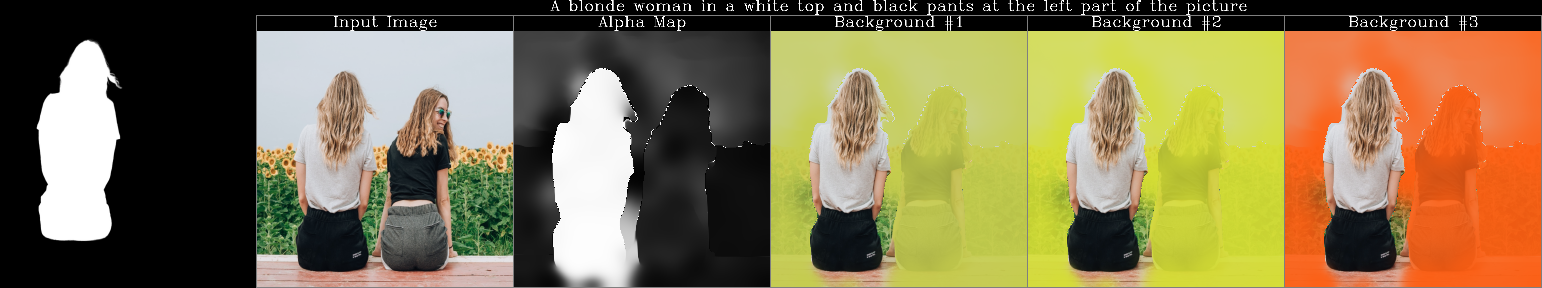



0.915980032477296


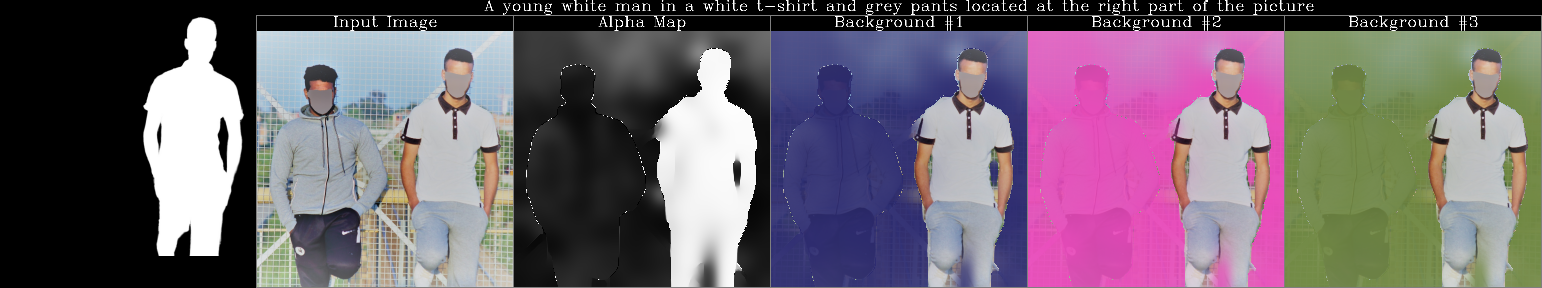



0.8867893925877869


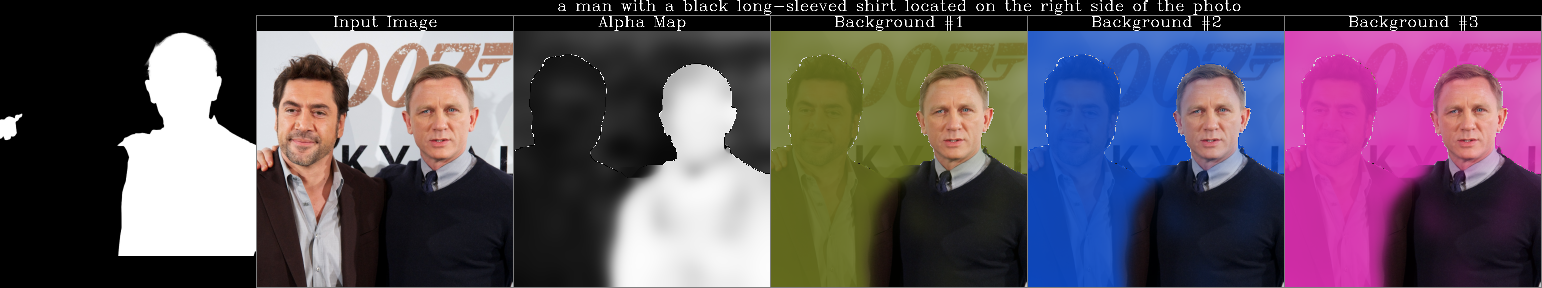



0.8783768760422457


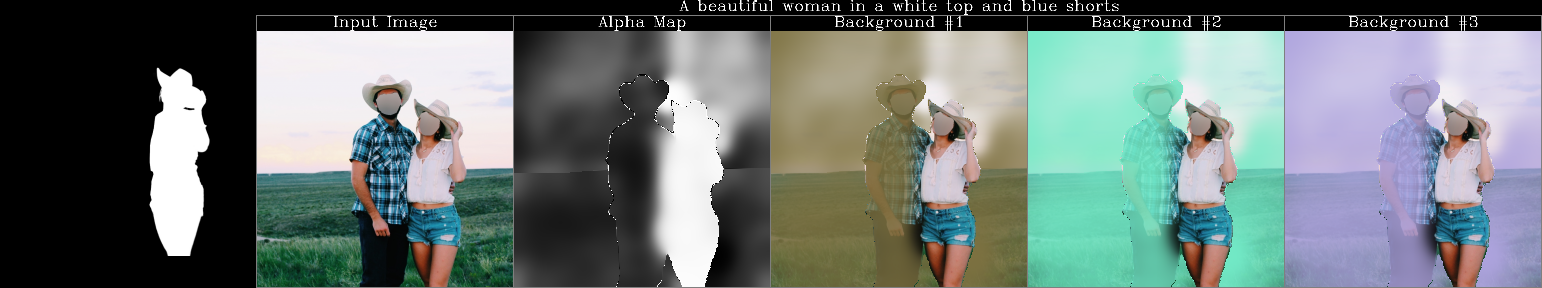



0.8653219413370915


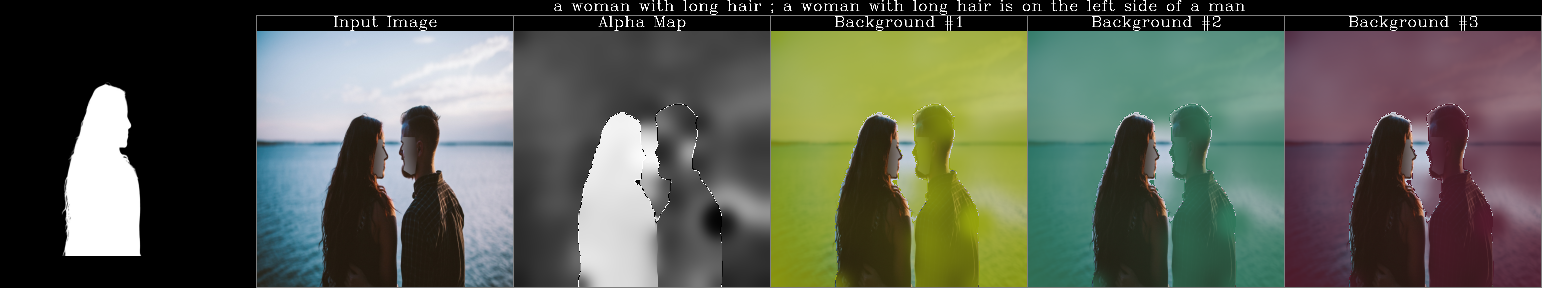



0.8650843222985634


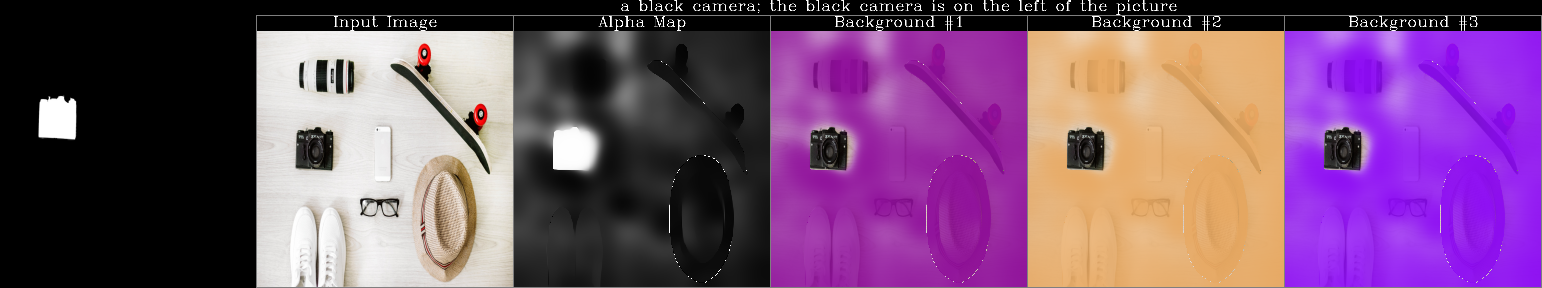

In [11]:
for i in range(10):
    bri=best_results[i]
    print(get_best_iou(bri))
    rp.display_image(rp.horizontally_concatenated_images(bri.mask,bri.preview_image))
    print()
    print()

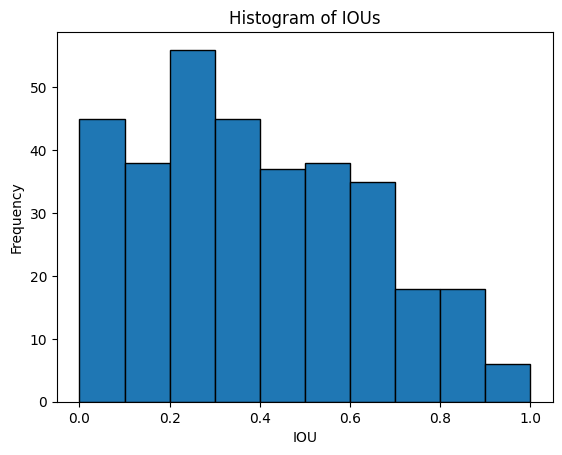

ic| rp.median(ious): 0.35827405728590933
    rp.mean(ious): 0.39253736878584905


(0.35827405728590933, 0.39253736878584905)

In [29]:
ious=[get_best_iou(result) for result in results]
sorted(ious)
import matplotlib.pyplot as plt

def display_histogram(scores: list):
    # Create a histogram with 10 bins
    plt.hist(scores, bins=10, range=(0, 1), edgecolor='black')

    # Add labels and title
    plt.xlabel('IOU')
    plt.ylabel('Frequency')
    plt.title('Histogram of IOUs')

    # Display the histogram
    plt.show()
    
display_histogram(ious)
ic(rp.median(ious),rp.mean(ious))

In [32]:
clusters=cluster_by_key(results, key=lambda x:(x.preset_name, x.square_image_method),as_dict=True)
rp.pretty_print({cat:mean(x.best_iou for x in clusters[cat]) for cat in clusters})

{
    ('midas_raster_bilateral_low_grav_bilat0rgb_sd15__100iter', 'crop'): 0.3752365287630614,
    ('midas_raster_bilateral_low_grav_bilat0rgb_sd15__200iter', 'crop'): 0.41401434533884485,
    ('midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter', 'crop'): 0.4028542431318081,
    ('raster_bilateral', 'crop'): 0.4002744577351989,
    ('midas_raster_bilateral_low_grav_bilat0rgb_sd15__100iter', 'scale'): 0.4010219233522028,
    ('midas_raster_bilateral_low_grav_bilat0rgb_sd15__200iter', 'scale'): 0.4369261752369956,
    ('midas_raster_bilateral_low_grav_bilat0rgb_sd15__50iter', 'scale'): 0.3781174728821201,
    ('raster_bilateral', 'scale'): 0.3338726710522398
}



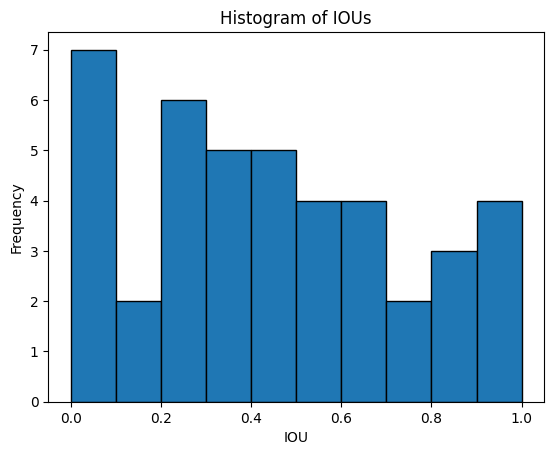

ic| rp.median(cluster_ious): 0.42618490519031116
    rp.mean(cluster_ious): 0.43692617523699556


(0.42618490519031116, 0.43692617523699556)

In [33]:
cluster_ious=[x.best_iou for x in clusters[('midas_raster_bilateral_low_grav_bilat0rgb_sd15__200iter', 'scale')]]
display_histogram(cluster_ious)
ic(rp.median(cluster_ious),rp.mean(cluster_ious))